In [1]:
import concurrent.futures
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import threading
import yfinance as yf

In [2]:
altimeter_ticker_string = "ADBE, ADSK, AI, ALVR, AMPL, APPF, APPN, ASAN, AYX, BASE, BIGC, BILL, BL, BNFT, BOX, BRZE, CFLT, COUP, CSOC, CRM, CRWD, CXM, DATA, DBX, DDOG, DOCU, DOMO, DT, DWRE, EGHT, ESTC, EVCM, FIVN, FROG, FRSH, FSLY, GLBE, GTLB, GWRE, HCP, HUBS, IOT, JAMF, KLTR, LAW, LNKD, MDB, MDLA, MKTO, MNDY, MNTV, MSFT, MULE, N, NCNO, NET, NEWR, NOW, OLO, OKTA, ONTF, PCTY, PD, PANW, PATH, PAYC, PING, PCOR, PFPT, PLAN, PLTR, PS, PVTL, QLYS, QTWO, RNG, RP, RSKD, S, SHOP, SMAR, SNOW, SPLK, SPT, SQSP, SSNC, SUMO, TDC, TEAM, TENB, TLND, TWLO, TWOU, U, VEEV, WDAY, WIX, WKME, WORK, XM YEXT, ZEN, ZI, ZM, ZS, ZUO"
altimeter_tickers = [ticker.replace(' ', '') for ticker in altimeter_ticker_string.split(',')]

In [4]:
class SoftwareMultipleCalculator:
    def __init__(self, tickers, threads=10):
        self.threads = threads
        self.tickers = tickers
        self.skips = 0
        self.ev_revenue = {}
        self.ev_fcf = {}
        self.ev_revenue_stats = {'mean': None, 'median': None, 'std': None}
        self.ev_fcf_stats = {'mean': None, 'median': None, 'std': None}
        self.pool = concurrent.futures.ThreadPoolExecutor(max_workers=threads)
        
    def compute_ev(self, market_cap, debt, cash):
        return market_cap + debt - cash
        
    def compute_multiples(self, ticker):
        stock = yf.Ticker(ticker)

        try:
            market_cap = stock.info['marketCap']
            debt = stock.info.get('totalDebt', 0)
            cash = stock.info.get('totalCash', 0)

            ev = self.compute_ev(market_cap, debt, cash)
            revenue = stock.financials.loc['Total Revenue'][0]
            fcf = stock.cashflow.loc['Free Cash Flow'][0]

            ev_revenue = ev / revenue if revenue else None
            ev_fcf = ev / fcf if fcf else None

            if ev_revenue is not None and not np.isnan(ev_revenue):
                self.ev_revenue[ticker] = ev_revenue
            if ev_fcf is not None and not np.isnan(ev_fcf):
                self.ev_fcf[ticker] = ev_fcf

        except KeyError as e:
            print(f"Data not available for {ticker}: {e}")
            self.skips += 1
            
    def chunk_tickers(self):
        chunk_size = len(self.tickers) // self.threads
        remainder = len(self.tickers) % self.threads
        chunks = [self.tickers[i:i + chunk_size] for i in range(0, len(self.tickers)-remainder, chunk_size)]
        for i in range(remainder):
            chunks[i % self.threads].append(self.tickers[-(i+1)])
        print("Chunking Tickers into {} chunks with average size {}".format(len(chunks), chunk_size))
        return chunks
    
    def process_tickers(self):
        chunks = self.chunk_tickers()
        for chunk in chunks:
            for ticker in chunk:
                self.pool.submit(self.compute_multiples, ticker)
        self.pool.shutdown(wait=True)
        print("Skipped {} tickers. Processed {} total.".format(self.skips, len(self.tickers) - self.skips))
        self.sort_data()
        
    def sort_data(self):
        self.ev_revenue = dict(sorted(self.ev_revenue.items(), key=lambda item: item[1]))
        self.ev_fcf = dict(sorted(self.ev_fcf.items(), key=lambda item: item[1]))
        
    def compute_summary_stats(self):
        ev_revenue_values = list(self.ev_revenue.values())
        ev_fcf_values = list(self.ev_fcf.values())
        
        if ev_revenue_values:
            self.ev_revenue_stats['mean'] = np.mean(ev_revenue_values)
            self.ev_revenue_stats['median'] = np.median(ev_revenue_values)
            self.ev_revenue_stats['std'] = np.std(ev_revenue_values)
        
        if ev_fcf_values:
            self.ev_fcf_stats['mean'] = np.mean(ev_fcf_values)
            self.ev_fcf_stats['median'] = np.median(ev_fcf_values)
            self.ev_fcf_stats['std'] = np.std(ev_fcf_values)
    
    def summary_stats(self):
        self.compute_summary_stats()
        print("Summary Statistics:")
        print(f"  Total: {len(self.ev_revenue)}")
        print("-" * 20)
        print("EV/Revenue:")
        print(f"  Mean: {self.ev_revenue_stats['mean']}")
        print(f"  Median: {self.ev_revenue_stats['median']}")
        print(f"  Standard Deviation: {self.ev_revenue_stats['std']}")
        print("-" * 20)
        print("EV/FCF:")
        print(f"  Mean: {self.ev_fcf_stats['mean']}")
        print(f"  Median: {self.ev_fcf_stats['median']}")
        print(f"  Standard Deviation: {self.ev_fcf_stats['std']}")        
    
    def plot_multiples(self):

        if self.ev_revenue:
            plt.figure(figsize=(20, 10))
            plt.bar(self.ev_revenue.keys(), self.ev_revenue.values(), color='blue', label='EV/Revenue', width=0.5)
            plt.axhline(self.ev_revenue_stats['median'], color='red', linestyle='--', label='Median')
            plt.xlabel('Tickers')
            plt.ylabel('EV/Revenue')
            plt.title('EV/Revenue Multiples (Sorted)')
            plt.xticks(rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print("No valid EV/Revenue multiples to plot.")

        # Plot EV/FCF
        if self.ev_fcf:
            plt.figure(figsize=(20, 10))
            plt.bar(self.ev_fcf.keys(), self.ev_fcf.values(), color='green', label='EV/FCF', width=0.5)
            plt.axhline(self.ev_fcf_stats['median'], color='red', linestyle='--', label='Median')
            plt.xlabel('Tickers')
            plt.ylabel('EV/FCF')
            plt.title('EV/FCF Multiples (Sorted)')
            plt.xticks(rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print("No valid EV/FCF multiples to plot.")
    
    def export_to_csv(self, filename):
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Ticker', 'EV/Revenue', 'EV/FCF'])
            
            all_tickers = set(self.ev_revenue.keys()).union(set(self.ev_fcf.keys()))
            
            for ticker in all_tickers:
                ev_revenue = self.ev_revenue.get(ticker, 'N/A')
                ev_fcf = self.ev_fcf.get(ticker, 'N/A')
                writer.writerow([ticker, ev_revenue, ev_fcf])
        
        print(f"Data exported to {filename}")
        

In [5]:
tech = SoftwareMultipleCalculator(altimeter_tickers)
tech.process_tickers()

Chunking Tickers into 10 chunks with average size 10


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AYX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AYX&crumb=5t2NsM3jNhX


Data not available for AYX: 'marketCap'
Data not available for BNFT: 'marketCap'
Data not available for COUP: 'marketCap'
Data not available for CSOC: 'Total Revenue'
Data not available for DATA: 'marketCap'
Data not available for DWRE: 'marketCap'
Data not available for LNKD: 'marketCap'
Data not available for MKTO: 'marketCap'
Data not available for MNTV: 'marketCap'
Data not available for ZEN: 'marketCap'Data not available for MDLA: 'marketCap'

Data not available for MULE: 'marketCap'
Data not available for N: 'marketCap'


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NEWR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NEWR&crumb=5t2NsM3jNhX


Data not available for NEWR: 'marketCap'
Data not available for PING: 'marketCap'
Data not available for PFPT: 'marketCap'
Data not available for PLAN: 'marketCap'
Data not available for PVTL: 'marketCap'
Data not available for PS: 'marketCap'
Data not available for RP: 'marketCap'


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPLK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SPLK&crumb=5t2NsM3jNhX


Data not available for SPLK: 'marketCap'
Data not available for SUMO: 'marketCap'
Data not available for TLND: 'marketCap'
Data not available for WORK: 'marketCap'


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/XMYEXT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=XMYEXT&crumb=5t2NsM3jNhX


Data not available for XMYEXT: 'marketCap'
Skipped 25 tickers. Processed 80 total.


In [6]:
tech.summary_stats()

Summary Statistics:
  Total: 77
--------------------
EV/Revenue:
  Mean: 7.4287422103122305
  Median: 5.950371854615567
  Standard Deviation: 5.527216339217648
--------------------
EV/FCF:
  Mean: 30.997827807254378
  Median: 29.11693704212308
  Standard Deviation: 139.97122734361722


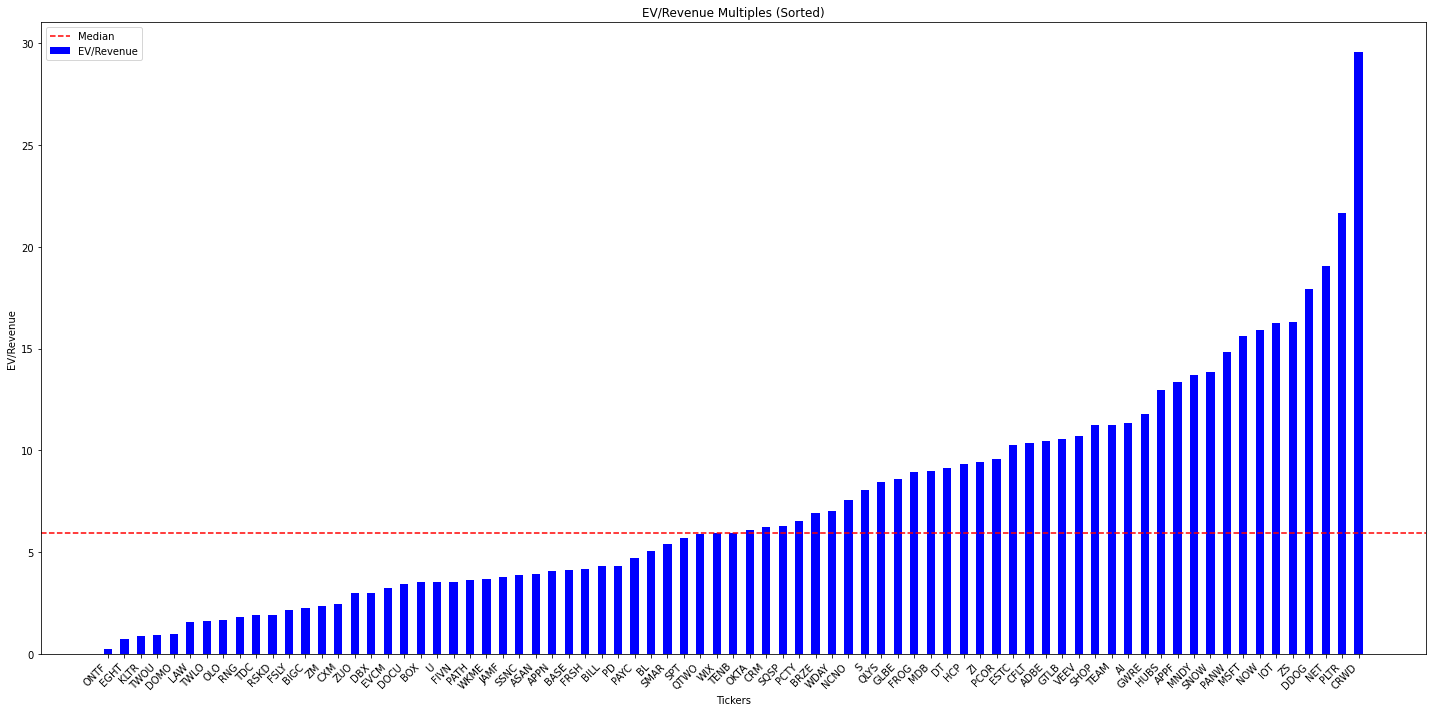

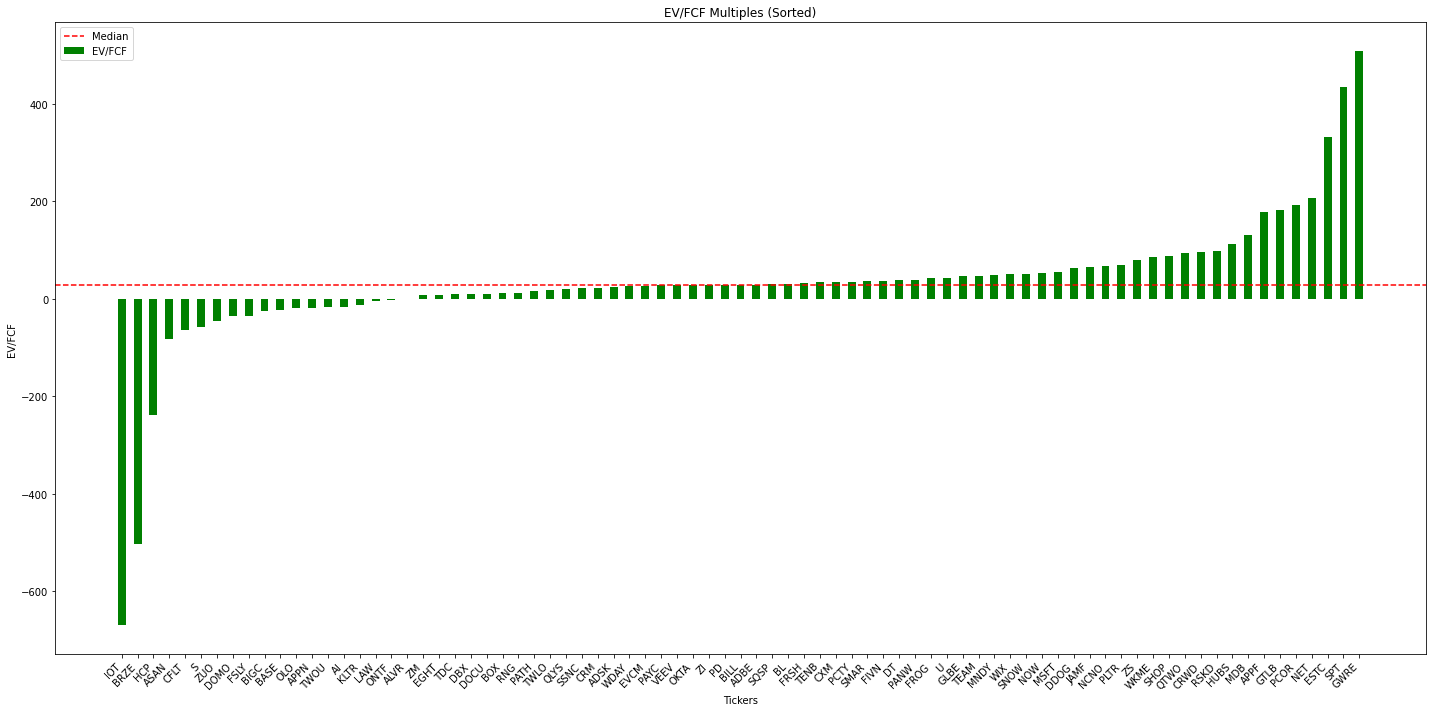

In [8]:
tech.plot_multiples()

In [9]:
tech.export_to_csv('tech-multiples.csv')

Data exported to tech-multiples.csv
